- A well justified evaluation framework.
- Pre-processing the data set to make it suitable for providing to various machine learning algorithms.
- Carefully selected and justified baseline model(s).
- Hyper-parameter setting and tuning to refine the model.
- Analysing model and outputs & interpreting the trained models

In reality we are classifying the nuclei type.
TODO: softmax CNN + NEP for classifying cell types

TODO: transfer learning, use one pre-trained model as basis for 2nd one, aka use extraData classification for mainData classification

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
from PIL import Image
import seaborn as sns

data = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
data.head(rows)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
5,22410,1,22410.png,fibroblast,0,0
6,22411,1,22411.png,fibroblast,0,0
7,22412,1,22412.png,fibroblast,0,0
8,22413,1,22413.png,fibroblast,0,0
9,22414,1,22414.png,fibroblast,0,0


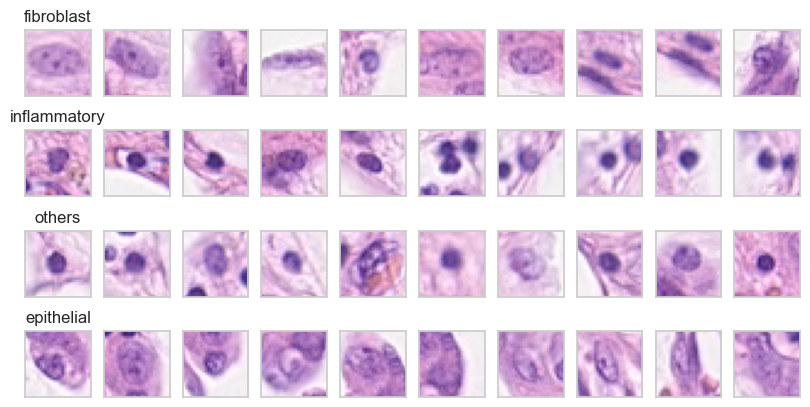

In [166]:
def cell_image(imageName):
    return Image.open('Image_classification_data/patch_images/' + imageName)


rows = 20
    
# # Convert to RGB mode (if not already in RGB mode)
# img = img.convert("RGB")

# # Get the RGB pixel values as a list of tuples
# rgb_pixels = list(img.getdata())

    
# Source: Week 4 Lecture Q and A

plt.figure(figsize=(10,5))
cell_types = data['cellTypeName'].unique()
for i, cell_type in enumerate(cell_types):
    cell_type_data = data[data['cellTypeName'] == cell_type][:10] 
    for j, image_name in enumerate(cell_type_data['ImageName']):
        plt.subplot(len(cell_types), 10, (i*10)+j+1) 
        plt.imshow(cell_image(image_name)) 
        plt.xticks([])
        plt.yticks([])
        if j==0:
            plt.title(cell_type) 
plt.show()

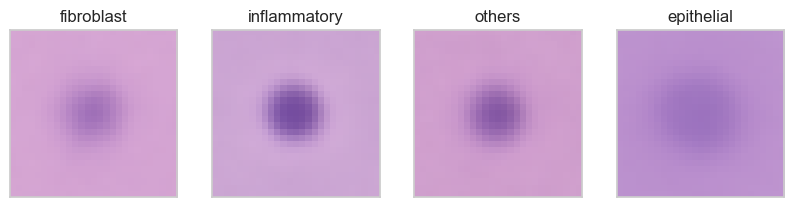

In [182]:
# Get the average cell image from all cell images 
# filter the data to only include images with the chosen cell type
plt.figure(figsize=(10,10))
for i, cell_type in enumerate(cell_types):
    cell_type_data = data[data['cellTypeName'] == cell_type]
    image_arrays = [np.array(cell_image(image_name)) for image_name in cell_type_data['ImageName']]
    average_array = np.mean(image_arrays, axis=0).astype(np.uint8)
    average_image = Image.fromarray(average_array)
    plt.subplot(len(cell_types), 4, i+1) 
    plt.imshow(average_image)
    plt.xticks([])
    plt.yticks([])
    plt.title(cell_type)
plt.show()

In classification, morphology of nuclei (shape, size, color, and texture) is
necessary to distinguish between different types of them. Raw RGB color intensities which constitute the overall visual
appearance of nuclei were, thus, chosen as input features to
softmax CNN for each patch.

## Image averaging
Epithelial have  the weakest nuclei positioning, as the center position is blurred, while inflammatory cells have the strongest.
The colour of epithelial cells is a stronger hue of purple, which may contribute to its morphology to distinguish its type.

# Get value counts of categorical variables
for column in {'cellTypeName', 'cellType', 'isCancerous'}:
    print(pd.value_counts(data[column]))
data.head()

# Get total unique patients
patients = len(data['patientID'].unique())
print(f"There are {patients} unique patients")

Cell type simply corresponds to the cell type name. To avoid affecting the model, we will take out the duplicate column
The instance ID is an ID column to uniquely identify the patient and cell together, so it is not necessary for analysis.

In [126]:
if 'InstanceID' in data.columns:
    data = data.drop(columns=['InstanceID', 'cellType'])
data.head()

,patientID,ImageName,cellTypeName,isCancerous
0,1,22405.png,fibroblast,0
1,1,22406.png,fibroblast,0
2,1,22407.png,fibroblast,0
3,1,22408.png,fibroblast,0
4,1,22409.png,fibroblast,0


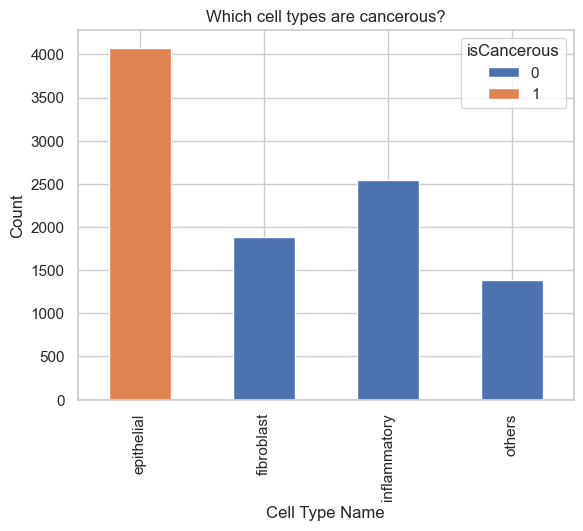

In [141]:
# Stacked bar chart 
grouped_data = data.groupby(['cellTypeName', 'isCancerous']).size().reset_index(name='count')
pivoted_data = grouped_data.pivot(index='cellTypeName', columns='isCancerous', values='count')
pivoted_data.plot(kind='bar', stacked=True)
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.title('Which cell types are cancerous?')
plt.show()

The dataset indicates that most cancer cells are epithelial in nature. However, the other cells may still play a role in cancer development. An example of this is inflammation cells causing chronic inflammation, which can damage DNA and other cellular components leading to cancer. [Link](https://www.cancer.gov/news-events/cancer-currents-blog/2022/reducing-inflammation-to-treat-cancer#:~:text=In%20a%20normal%20inflammatory%20response,that%20could%20lead%20to%20cancer)

TODO:
For this, it will be useful to identify the distribution of these cells per patient.

Other points:
- the extra data set may give better insight into classifying. first use both to classify cell type, then use to predict isCancerous

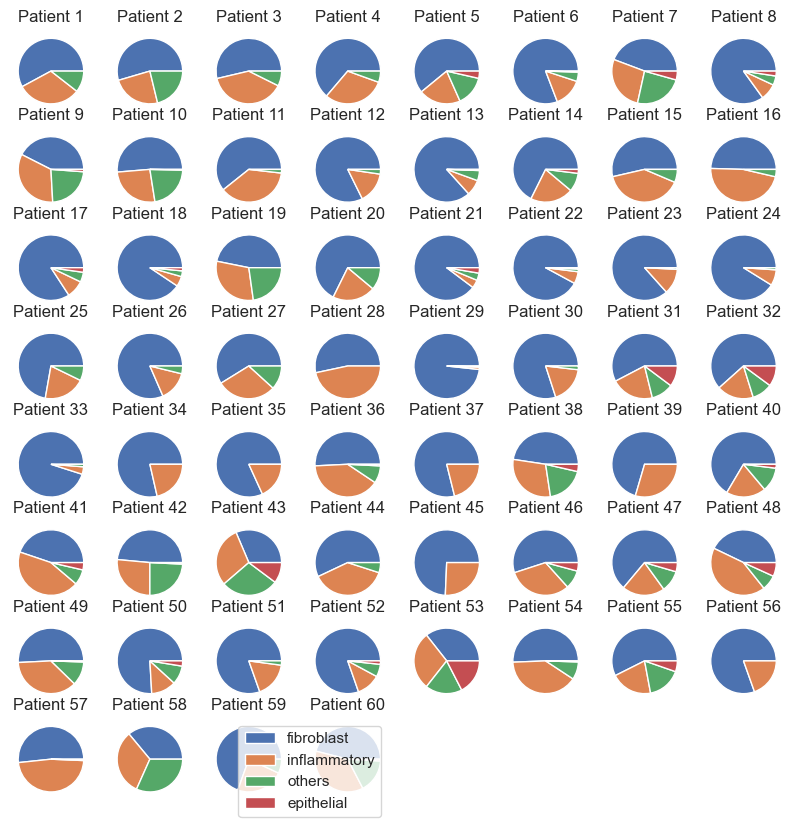

In [181]:

fig = plt.figure(figsize=(10,10))
for i, (patient_id, group) in enumerate(data.groupby("patientID")):
    cell_type_counts = group["cellTypeName"].value_counts()
    ax = fig.add_subplot(8, 8, i+1)
    
    ax.pie(cell_type_counts)
    ax.set_title(f"Patient {patient_id}")
plt.legend(data["cellTypeName"].unique())
plt.show()

We have identified that there are 60 unique patients in our dataset, with multiple cells allocated to each patient.
To avoid data leakage, we need to group any data for each patient and split the data such that there is no overlap of patient data between train, validation and test sets.

One more problem is ensuring that we maintain a rough 60-20-20 split, as certain patients may contain a larger proportion of the dataset, which may cause uneven distribution. This is another reason we specify a random state


In [54]:
# 60-20-20 split
def group_split(test_size, data):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

    # Split the data into training and test sets
    for train_idx, test_idx in gss.split(data, groups=data['patientID']):
        train_data = data.loc[train_idx]
        test_data = data.loc[test_idx]
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)


train_data, test_data = group_split(0.2, data)
train_data, val_data = group_split(0.25, train_data)

In [60]:
train_patients = train_data['patientID'].unique()
test_patients = test_data['patientID'].unique()
val_patients = val_data['patientID'].unique()
all_patients = np.unique(np.concatenate((train_patients, test_patients, val_patients), axis=0))
print(f"There are {len(all_patients)} unique patients after splitting, spread across the train, test and validation sets.")
overlap = len(np.intersect1d(train_patients, test_patients))

def overlap(train_data, test_data):
    train_patients = train_data['patientID'].unique()
    test_patients = test_data['patientID'].unique()
    return len(np.intersect1d(train_patients, test_patients))

print(f"There is {overlap(train_data, test_data)} overlap between the train and test patient data")
print(f"There is {overlap(train_data, val_data)} overlap between the train and validation patient data\n")

# Calculate the proportions of each dataset
train_prop = len(train_data) / len(data)
test_prop = len(test_data) / len(data)
val_prop = len(val_data) / len(data)

print(f"Train proportion: {train_prop:.2f}")
print(f"Test proportion: {test_prop:.2f}")
print(f"Validation proportion: {val_prop:.2f}")

There are 60 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.63
Test proportion: 0.18
Validation proportion: 0.19


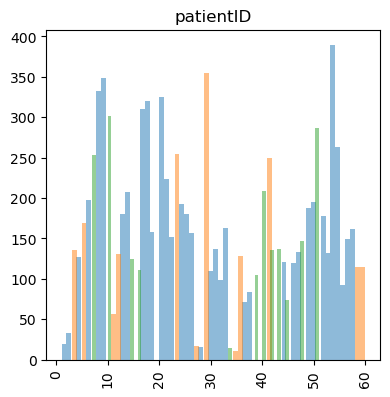

In [61]:
plt.figure(figsize=(25,30))
plt.subplot(6,5,1)
plt.hist(train_data['patientID'], bins = patients, alpha=0.5)
plt.hist(test_data['patientID'], bins = patients, alpha=0.5)
plt.hist(val_data['patientID'], bins = patients, alpha=0.5)
plt.title('patientID')
plt.xticks(rotation='vertical')
print()

TODO:
Eval metrics: Weighted average F1-score, Multi-class AUC, Epithelial Precision (for isCancerous) 